# 💸 Mood & Money: Sentiment-Aware Trading Strategy (Tesla)

This project simulates a simple trading strategy based on the **sentiment of fake Tesla headlines**.  
Using `vaderSentiment` to measure market "mood," the strategy buys TSLA stock when sentiment is positive, and sells when it turns negative. 📈📉



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [3]:
fake_headlines = [
    "Tesla reports record profits 🚀",
    "Elon Musk tweets something wild 😬",
    "Tesla misses delivery estimates 😔",
    "New Tesla Gigafactory opens! 🏭",
    "Cybertruck delayed again 😕",
    "Tesla faces lawsuit over crash ⚖️",
    "Tesla joins S&P 500 📈",
    "Worries about interest rates 🧯",
    "Elon hints at a new product launch 📡",
    "Analysts upgrade Tesla stock ✅"
]

dates = pd.date_range(start="2023-01-01", periods=len(fake_headlines), freq='W')
headlines_df = pd.DataFrame({"Date": dates, "Headline": fake_headlines})
headlines_df.head()


,Date,Headline
0,2023-01-01,Tesla reports record profits 🚀
1,2023-01-08,Elon Musk tweets something wild 😬
2,2023-01-15,Tesla misses delivery estimates 😔
3,2023-01-22,New Tesla Gigafactory opens! 🏭
4,2023-01-29,Cybertruck delayed again 😕


In [9]:
analyzer = SentimentIntensityAnalyzer()
headlines_df['Sentiment'] = headlines_df['Headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
headlines_df


,Date,Headline,Sentiment
0,2023-01-01,Tesla reports record profits 🚀,0.4404
1,2023-01-08,Elon Musk tweets something wild 😬,-0.3400
2,2023-01-15,Tesla misses delivery estimates 😔,-0.1531
3,2023-01-22,New Tesla Gigafactory opens! 🏭,0.0000
4,2023-01-29,Cybertruck delayed again 😕,-0.4939
5,2023-02-05,Tesla faces lawsuit over crash ⚖️,-0.5574
6,2023-02-12,Tesla joins S&P 500 📈,0.0000
7,2023-02-19,Worries about interest rates 🧯,-0.2960
8,2023-02-26,Elon hints at a new product launch 📡,0.0000
9,2023-03-05,Analysts upgrade Tesla stock ✅,0.0000


In [13]:
# Download full stock data (may come with MultiIndex columns)
stock_df = yf.download("TSLA", start="2023-01-01", end="2024-01-01")

# If it has MultiIndex columns (like 'Close' under multiple levels), flatten them
if isinstance(stock_df.columns, pd.MultiIndex):
    stock_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in stock_df.columns]

# Reset index to move 'Date' into a column
stock_df = stock_df.reset_index()

# Only keep 'Date' and 'Close' (flat now, might be called 'Close' or 'Close_Close')
close_col = [col for col in stock_df.columns if 'Close' in col][0]
stock_df = stock_df[['Date', close_col]]
stock_df.rename(columns={close_col: 'Close'}, inplace=True)

stock_df.head()





[*********************100%***********************]  1 of 1 completed


,Date,Close
0,2023-01-03,108.099998
1,2023-01-04,113.639999
2,2023-01-05,110.339996
3,2023-01-06,113.059998
4,2023-01-09,119.769997


In [14]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
headlines_df['Date'] = pd.to_datetime(headlines_df['Date'])



In [15]:
merged_df = pd.merge(stock_df, headlines_df, on="Date", how="left")
merged_df['Sentiment'] = merged_df['Sentiment'].fillna(method='ffill')
merged_df.head()


C:\Users\braki\AppData\Local\Temp\ipykernel_44028\18187240.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['Sentiment'] = merged_df['Sentiment'].fillna(method='ffill')


,Date,Close,Headline,Sentiment
0,2023-01-03,108.099998,NaN,NaN
1,2023-01-04,113.639999,NaN,NaN
2,2023-01-05,110.339996,NaN,NaN
3,2023-01-06,113.059998,NaN,NaN
4,2023-01-09,119.769997,NaN,NaN


In [16]:
initial_cash = 10000
cash = initial_cash
shares = 0
portfolio_values = []

for i in range(len(merged_df)):
    price = merged_df['Close'].iloc[i]
    mood = merged_df['Sentiment'].iloc[i]
    
    # Buy if sentiment is strongly positive
    if mood > 0.2 and cash > 0:
        shares = cash / price
        cash = 0
    # Sell if sentiment is strongly negative
    elif mood < -0.2 and shares > 0:
        cash = shares * price
        shares = 0
    
    total_value = cash + shares * price
    portfolio_values.append(total_value)

merged_df['Portfolio'] = portfolio_values
merged_df['BuyHold'] = initial_cash * (merged_df['Close'] / merged_df['Close'].iloc[0])


C:\Users\braki\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\braki\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


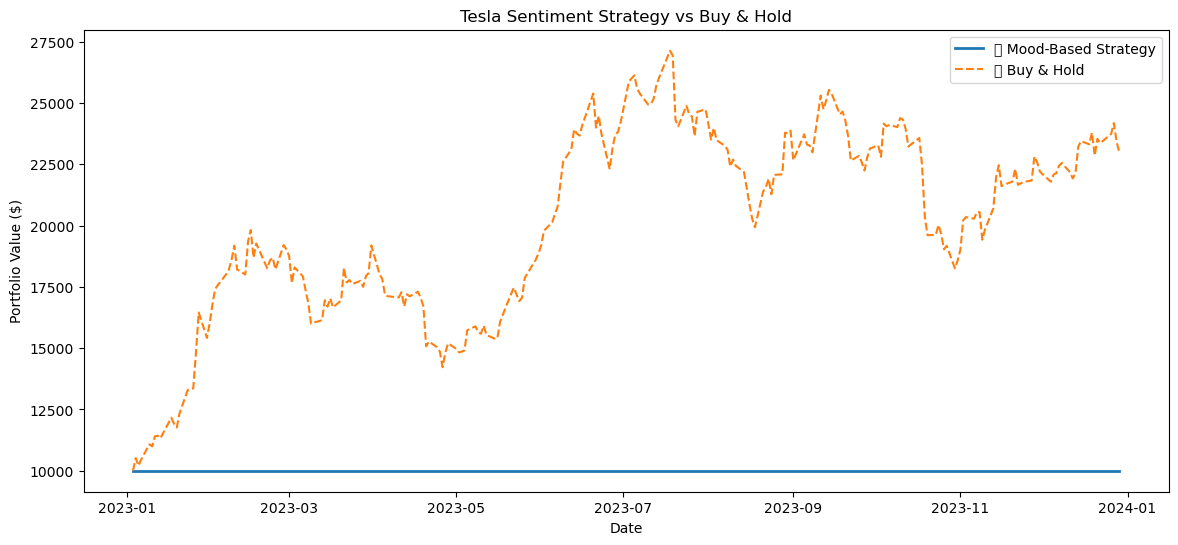

In [17]:
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['Portfolio'], label='🧠 Mood-Based Strategy', linewidth=2)
plt.plot(merged_df['Date'], merged_df['BuyHold'], label='📈 Buy & Hold', linestyle='--')
plt.title('Tesla Sentiment Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()


##  Summary

- Created a fun, mood-based trading assistant using fake Tesla headlines
- Used sentiment scoring (VADER) to decide when to buy or sell
- Compared strategy against a basic Buy and Hold approach


